In [1]:
import os
import sys
sys.path.append('../../../../')

import cv2
import copy
import numpy as np

%load_ext autoreload
%autoreload 2

from computer_vision.yolov11.modules.detector import DetectionModel
from computer_vision.yolov11.parameter_parser import parser
from computer_vision.yolov11.utils.check import check_imgsz
from computer_vision.yolov11.data.dataset import YOLODataset
from computer_vision.misc import alpha_bending
from computer_vision.yolov11.misc import instance2mask

In [2]:
data_dirpath=r'D:/data/ultralytics/coco128-seg'

argument=f'''--root {data_dirpath} --image-dirname images/train2017 --label-dirname labels/train2017
--data-cfg ../../coco128-seg.yaml --hyperparam ../../default.yaml '''
args=parser.parse_args(argument.split())

model=DetectionModel(cfg='../../yolo11.yaml', ch=3)
print('stride ', model.stride)
gs = max(int(model.stride.max() if hasattr(model, "stride") else 32), 32)  # grid size (max stride)
print('grid size ', gs)
check_imgsz(args.imgsz, stride=gs, floor=gs, max_dim=1) # args.imgsz 

dataset=YOLODataset(img_path=os.path.join(args.root, args.image_dirname),label_path=os.path.join(args.root, args.label_dirname),
                    data=args.data_cfg, hyp=args.hyperparam, imgsz=640, cache=True, augment=True, rect=False, batch_size=8, stride=32, pad=0.5, 
                    single_cls=False, classes=None, fraction=1., channels=3)

print('dataset.im_files ', len(dataset.im_files))

In BaseModel._predict_once max_idx -1 embed {-1}
stride  tensor([ 8., 16., 32.])
grid size  32
In data.dataset.YOLODataset.update_images_labels cache path D:\data\ultralytics\coco128-seg\labels\train2017.cache exist. Load it!!!
Scanning D:\data\ultralytics\coco128-seg\labels\train2017.cache ... 126 images with 2 missing and 0 empty files as well as 0 corrupt files
max_buffer_length  64  ni  128
dataset.im_files  128


In [3]:
from __future__ import annotations

import random
from typing import Any

import numpy as np

from computer_vision.yolov11.instance.instance import Instances
from computer_vision.yolov11.data.augment import Compose, Mosaic, MixUp, CutMix, RandomPerspective,\
RandomHSV, RandomFlip, LetterBox, CopyPaste
from computer_vision.yolov11.utils.ops import xywhn2xyxy, xywh2xyxy
from computer_vision.yolov11.data.utils import imread

from matplotlib import patches
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

In [4]:
from computer_vision.yolov11.data.utils import polygon2masks_overlap, polygon2masks

class Format:
    """
    A class for formatting image annotations for object detection, instance segmentation, and pose estimation tasks.

    This class standardizes image and instance annotations to be used by the `collate_fn` in PyTorch DataLoader
    """
    def __init__(self, bbox_format:str='xywh', normalize:bool=True, return_mask:bool=False, return_keypoint:bool=False,
                return_obb:bool=False, mask_ratio:int=4, mask_overlap:bool=True, batch_idx:bool=True, bgr:float=0.):
        """
        Initialize the Format class with given parameters for image and instance annotation formatting.
        Args:
            bbox_format (str): Format for bounding boxes. Options are `xywh`, `xyxy`, etc.
            normalize (bool): Whether to normalize bounding boxes to [0,1].
            return_mask (bool): If True, return instance masks for segmentation tasks
            return_keypoint (bool): If True, return keypoints for pose estimation tasks.
            return_obb (bool): If True, return oriented bounding boxes
            mask_ratio (int): Downsample ratio for masks.
            mask_overlap (bool): If True, allows mask overlap
            batch_idx (bool): If True, keep batch indices
            bgr (float): Probability of returning BGR images instead of RGB
        """
        self.bbox_format=bbox_format
        self.normalize=normalize
        self.return_mask=return_mask # set to False when training detection only
        self.return_keypoint=return_keypoint
        self.return_obb=return_obb
        self.mask_ratio=mask_ratio
        self.mask_overlap=mask_overlap
        self.batch_idx=batch_idx
        self.bgr=bgr

    def _format_segments(self, instances:Instances, cls:np.ndarray, w:int, h:int)->tuple[np.ndarray, Instances, np.ndarray]:
        """
        Convert polygon segments to masks
        Args:
            instances (Instances): Object containing segment information
            cls (np.ndarray): Class labels for each instances of size Nx1 for N instances
            w (int): Width of the image
            h (int): Height of the image
        Returns:
            masks (np.ndarray): Masks with shape (N,H,W) or (1,H,W) if mask_overlap is True
            instances (Instances): Updated instances object with sorted segments if mask_overlap is True
            cls (np.ndarray): Updated class labels, sorted if mask_overlap is True
        Notes:
            - If mask_overlap is True, masks are overlapped and sorted by area from large to small
            - If mask_overlap is False, each mask is represented seperately as a binary mask
            - Masks are downsampled according to mask_ratio
        """
        segments=instances.segments
        if self.mask_overlap:
            masks, sorted_idx=polygon2masks_overlap((h,w), segments, downsample_ratio=self.mask_ratio)
            masks=masks[None] # HxW -> 1xHxW
            instances=instances[sorted_idx] # from large to small
            cls=cls[sorted_idx]
        else:
            masks=polygon2masks((h, w), segments, color=1, downsample_ratio=self.mask_ratio)
        return masks, instances, cls
    
    def __call__(self, labels: dict[str, Any])->dict[str, Any]:
        """
        Format image annotations for object detection, instance segmentation, and pose estimation tasks

        This method standardizes the image and instance annotations to be used by the `collate_fn` in PyTorch DataLoader
        It processes the input labels dict, converting annotations to the specified format and applying normalization if required
        Args:
            labels (dict[str, Any]): A  dict containing image and annotation data with the following keys:
                - `img` (np.ndarray): The input image as a numpy array of size HxWxC 
                - `cls` (np.ndarray): Class labels for instances of size Nx1 where N is the number of objects
                - `instances` (Instances): An Instances object containing bounding boxes, segments, and keypoints
        Returns: 
            (dict[str, Any]): A dict with formatted data, including:
                - `img`: Formatted image tensor
                - `cls` : Class label's tensor
                - `bboxes`: Bounding box tensor in the specified format
                - `masks`: Instance masks tensor (if return_mask is True)
                - `keypoints`: Keypoint tensor (if return_keypoint is True)
                - `batch_idx`: Batch index tensor (if batch_idx is True)
        """
        img=labels.pop('img')
        h, w = img.shape[:2]
        cls=labels.pop('cls')
        instances=labels.pop('instances')
        instances.convert_bbox(format=self.bbox_format)
        instances.denormalize(w, h)
        nl=len(instances) # number of boxes/segmentations

        # if self.return_mask:
        #     if nl:
        #         masks, instances, cls=self._format_segments(instances, cls, w, h)
        pass

In [5]:
import yaml
from pathlib import Path 

hyp=Path(args.hyperparam)
assert hyp.is_file(), f'{hyp} does not exist'
with open(hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)

mosaic=Mosaic(dataset, imgsz=dataset.imgsz, p=hyp['mosaic'], n=4)
affine=RandomPerspective(degrees=hyp['degrees'], translate=hyp['translate'],
                        scale=hyp['scale'], shear=hyp['shear'], perspective=hyp['perspective'],
                        pre_transform=None)
pre_transform=Compose([mosaic, affine])
transforms=Compose([pre_transform,
                   MixUp(dataset, pre_transform=pre_transform, p=hyp['mixup']),
                   CutMix(dataset, pre_transform=pre_transform, p=hyp['cutmix']),
                   RandomHSV(hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v']),
                   RandomFlip(direction='vertical', p=hyp['flipud']),
                   RandomFlip(direction='horizontal', p=hyp['fliplr'])])

# transforms.append( 
#         Format(
#                 bbox_format="xywh",
#                 normalize=True,
#                 return_mask=True,
#                 return_keypoint=False,
#                 return_obb=False,
#                 batch_idx=True,
#                 mask_ratio=hyp['mask_ratio'],
#                 mask_overlap=hyp['overlap_mask'],
#                 bgr=hyp['bgr'] 
#             )
# )
formatting= Format(
                bbox_format="xywh",
                normalize=True,
                return_mask=True,
                return_keypoint=False,
                return_obb=False,
                batch_idx=True,
                mask_ratio=hyp['mask_ratio'],
                mask_overlap=hyp['overlap_mask'],
                bgr=hyp['bgr'] 
            )
print(f"hyp['mask_ratio'] {hyp['mask_ratio']}, hyp['overlap_mask'] {hyp['overlap_mask']}, hyp['bgr'] {hyp['bgr']}")
# labels=dataset.get_image_and_label(index=20) # 90, 10
# pre_labels=pre_transform(copy.deepcopy(labels))
# final_labels=transforms(labels)


hyp['mask_ratio'] 4, hyp['overlap_mask'] True, hyp['bgr'] 0.0


In [6]:
labels=dataset.get_image_and_label(index=20) # 90, 10
labels=transforms(labels)



img=labels.pop('img')
h, w = img.shape[:2]
cls=labels.pop('cls')
instances=labels.pop('instances')
instances.convert_bbox(format=formatting.bbox_format)
instances.denormalize(w, h)
nl=len(instances) # number of boxes/segmentations

In data.dataset.load_image self.buffer 1
In data.dataset.load_image self.buffer 2
In data.dataset.load_image self.buffer 3
In data.dataset.load_image self.buffer 4


In [7]:
# masks, instances, cls = self._format_segments(instances, cls, w, h)


segments  (11, 180, 2)


(True, 4, 640, 640)

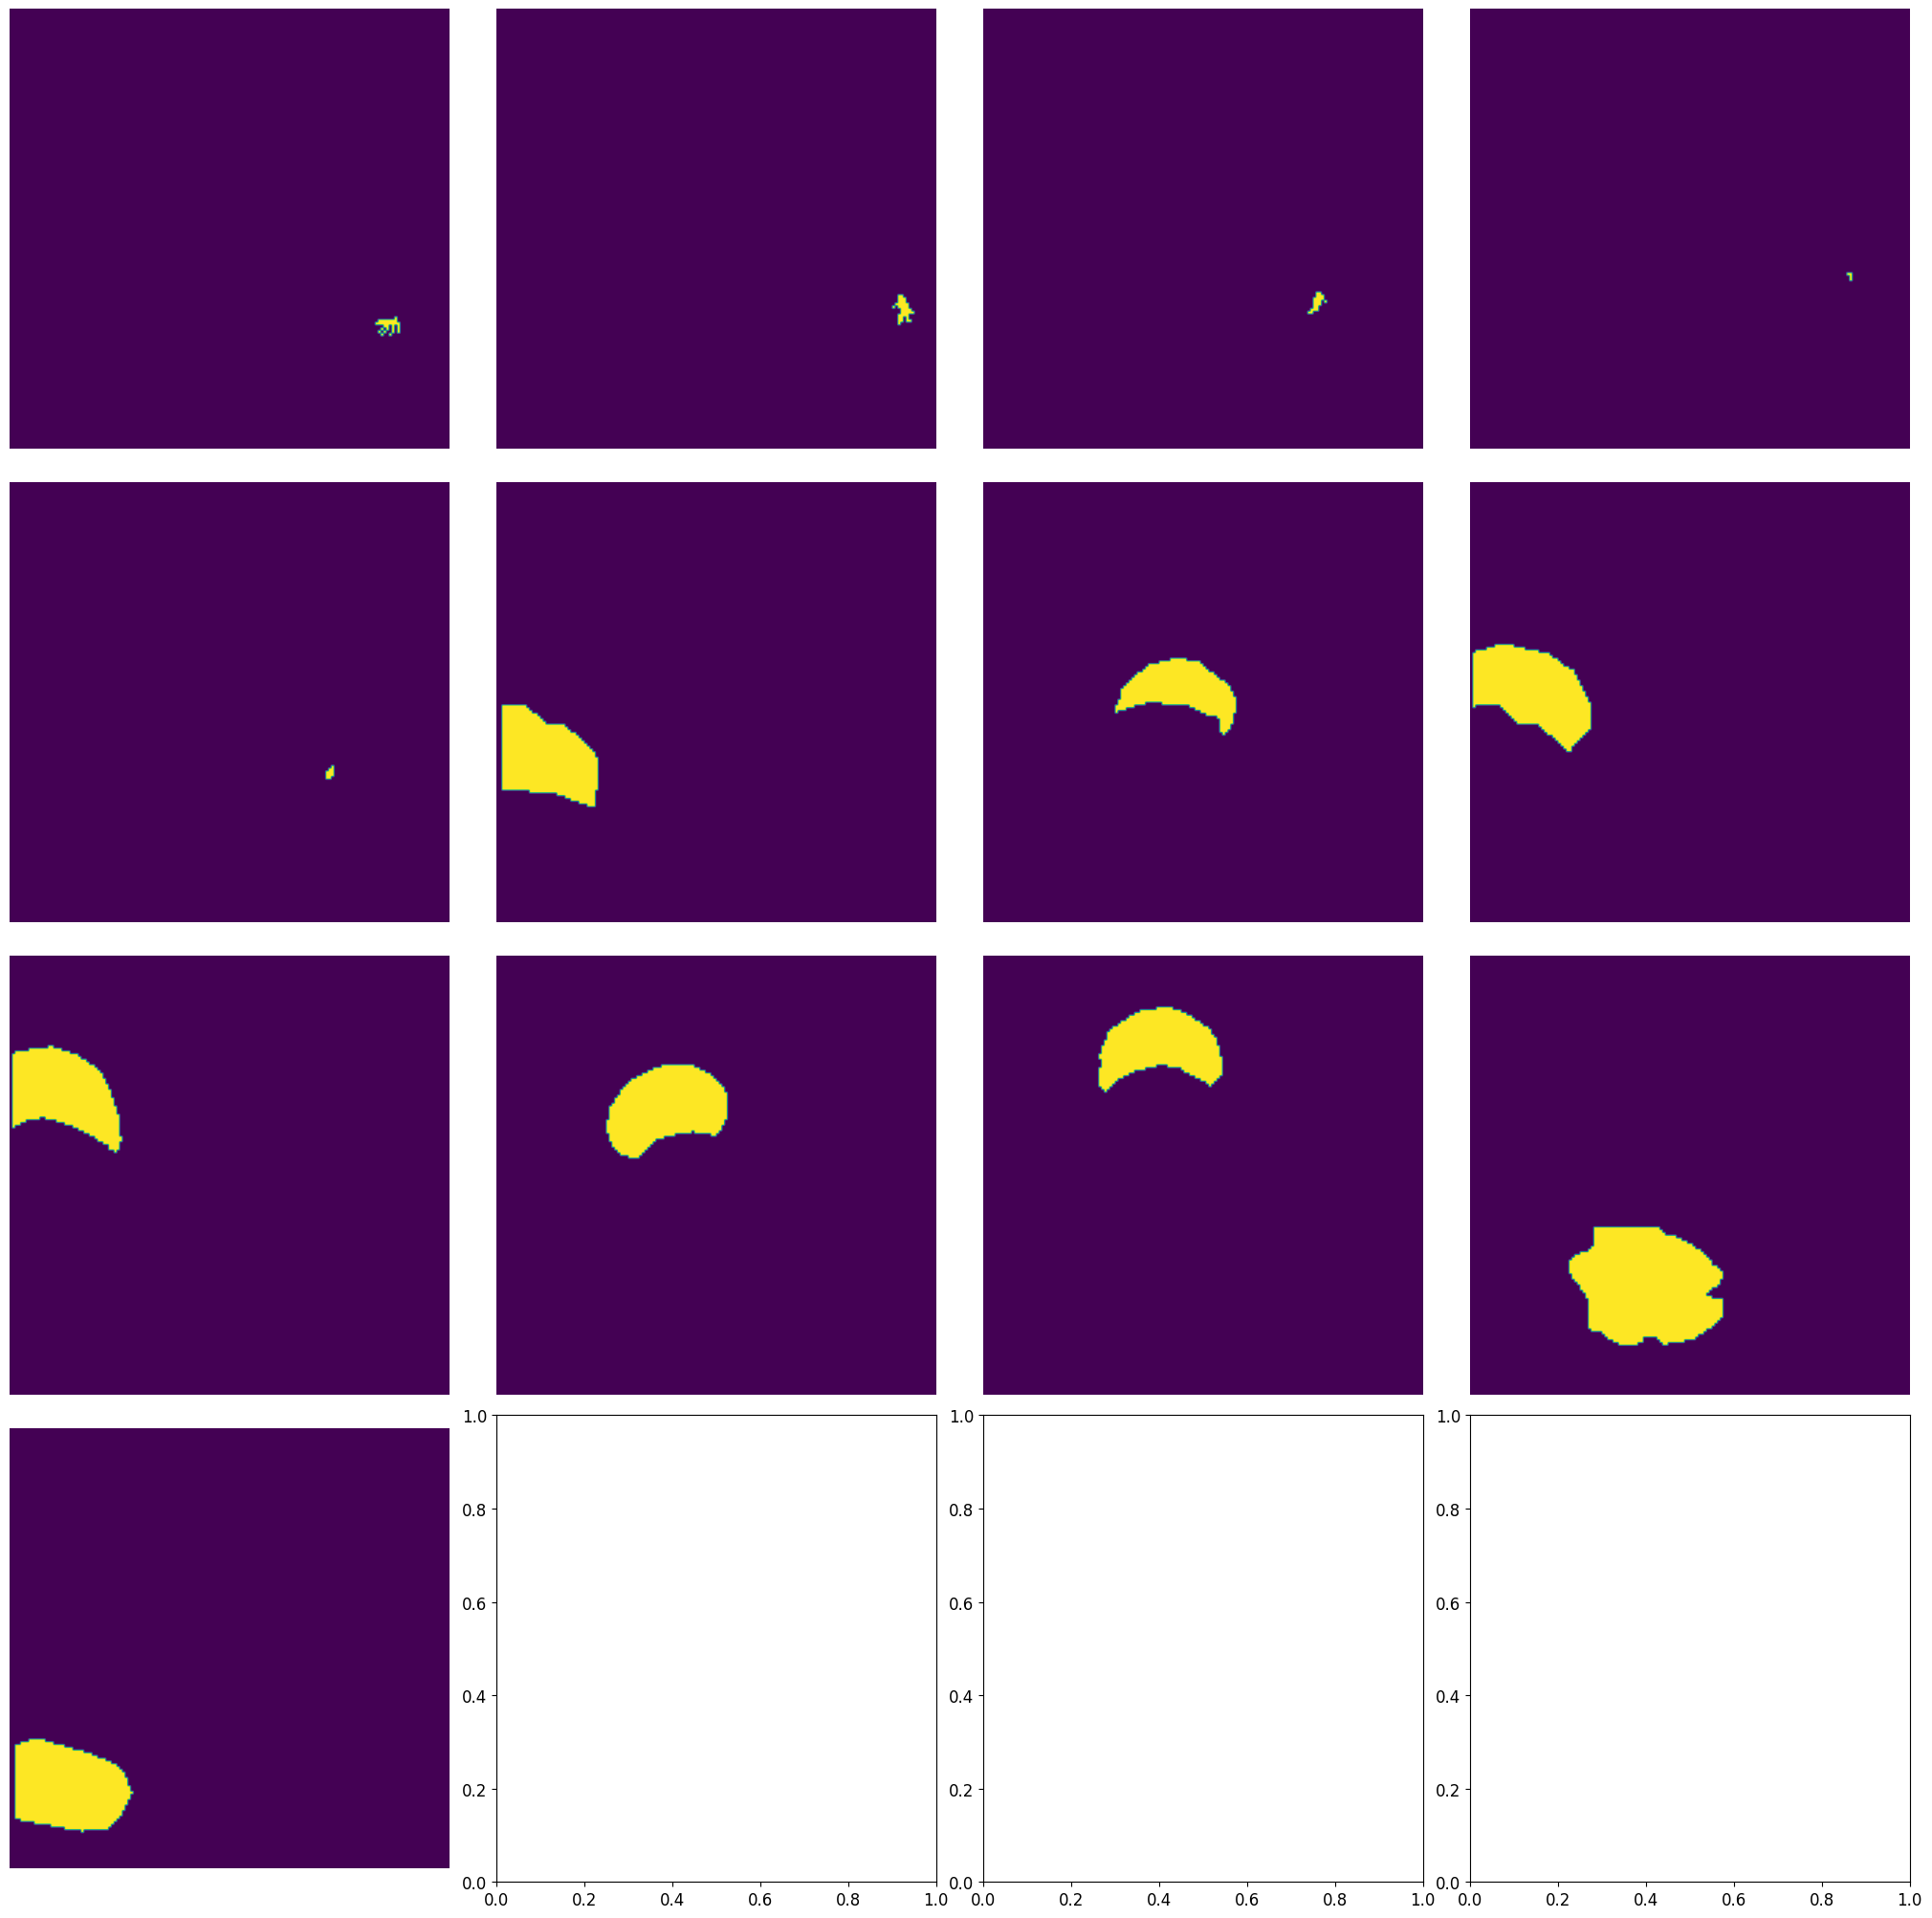

In [13]:
_, ax=plt.subplots(4,4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        i=r*4+c
        if i>=masks.shape[0]: break
        ax[r, c].imshow(masks[i])
        ax[r, c].axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

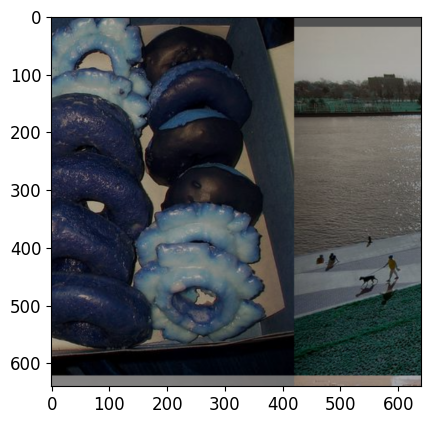

In [14]:
plt.imshow(img)

In [ ]:

_, ax=plt.subplots(1,2,figsize=(20,8))
for i, labels in enumerate([pre_labels, final_labels]):
    classes=[dataset.data['names'][int(c)] for c in labels['cls'].flatten()]
    img=labels['img']
    height, width=img.shape[:2]
    print('img ', img.shape, f'height {height}, width {width}')
    instances=copy.deepcopy(labels['instances'])
    if instances._bboxes.format=='xywh': instances.convert_bbox('xyxy')
    if instances.normalized: instances.denormalize()
    boxes=instances.bboxes

    mask=instance2mask(image=img, instance=labels['instances'])
    ax[i].imshow(alpha_bending(mask, img[...,::-1], 0.4))
    # ax[i].imshow(img[...,::-1])
    for j, (box,cls) in enumerate(zip(boxes, classes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].text(*box[:2], f'{cls}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
